In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import numpy as np
import tkinter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from statistics import mean
from statistics import stdev as std

pd.set_option("display.max_columns", None)

import matplotlib
import warnings
import statistics

warnings.filterwarnings('ignore')
%matplotlib inline

postive_vals = {} ## dict for postive MSRE $
negative_vals = {}# dict for negative MRSE ##


postive_vals_r2 = {} #dict for psotive r^2#
negative_vals_r2 = {} #dict for negative r^2#

postive_vals_mr2={}#dict for postive r^2 mean of cross validation#
negative_vals_mr2={}#dict for negative r^2 mean of cross validation#

postive_vals_std = {}#dict for postive std of cross validation#
negative_vals_std = {}#dict for negative std of cross validation#

def Season_maker_zaada(x):
    if x  in ["Jan","Feb","Dec"]:
        return "Winter"
    elif x  in ["Apr","May","Mar"]:
        return "Spring"
    elif x  in ["Jun","Jul","Aug"]:
        return "Summer"
    else:
        return 'Autumn'
    # Add elif statements
    
def merge_fix_cols(df_company,df_product,uniqueID):## merge 2 dataframes and remove the duplicate ## 

    df_merged = pd.merge(df_company,
                         df_product,
                         how='left',on=uniqueID)    
    for col in df_merged:
        if col.endswith('_x'):
            df_merged.rename(columns = lambda col:col.rstrip('_x'),inplace=True)
        elif col.endswith('_y'):
            to_drop = [col for col in df_merged if col.endswith('_y')]
            df_merged.drop(to_drop,axis=1,inplace=True)
        else:
            pass
    return df_merged

dataset = pd.read_csv("COVID-19_Daily_Testing_-_By_Test.csv") ## read the csv file ## 
dataset["unique_id_zaada"] = dataset.index + 1## insert insex for rows so later can be merged ##
first_column = dataset.pop('unique_id_zaada')
dataset.insert(0, 'unique_id_zaada', first_column)
## insert first colum of uniqe id ## 



df = dataset.sort_values(by="Date")## sort the values by date ## 
df.fillna(value=df.mean(), inplace=True) ## fil nulls with the mean ## 
df = df.drop(df[df.Date.isnull()].index) ## drop null dates ## 
df['Month']=df['Date'].astype('datetime64[ns]').dt.strftime('%b') # make featuer of the monuth according to the date ##

df['Season']=df['Month'].apply(Season_maker_zaada)

temp = df.pop('Day')
df.insert(5, 'Day', temp)## make day not in the begining ###


dfp = df[["Positive Tests","Tests - Age 0-17","Tests - Age 18-29","Tests - Age 30-39","Tests - Age 40-49","Tests - Age 50-59",
"Tests - Age 60-69","Tests - Age 70-79","Tests - Age 80+","Tests - Age Unknown","Tests - Female","Tests - Male",
"Tests - Gender Unknown","Tests - Latinx","Tests - Asian Non-Latinx","Tests - Black Non-Latinx",
"Tests - White Non-Latinx","Tests - Other Race Non-Latinx","Tests - Unknown Race/Ethnicity",
'Month','Day',"unique_id_zaada","Date","Season"]]

## for postive ##
enc =OneHotEncoder (sparse=False) ## make onehotencoder## 
onehot_Month= enc.fit_transform(dfp["Month"].values.reshape(-1,1))##reshape beacuse of eror#
Month=pd.DataFrame(onehot_Month, columns=enc.get_feature_names())## data frame of the onehotencoder##
Month["unique_id_zaada"] = dfp.index + 1## make unique id so can merge the dataframes ##
first_column = Month.pop("unique_id_zaada")#make uniqe id in the dataframe ## 
Month.insert(0, 'unique_id_zaada', first_column) ## make the uniqe id first col ## 
onehot_Day= enc.fit_transform(dfp["Day"].values.reshape(-1,1))##reshape beacuse of eror#
Day=pd.DataFrame(onehot_Day, columns=enc.get_feature_names())## data frame of the onehotencoder##
Day["unique_id_zaada"] = dfp.index + 1## make unique id so can merge the dataframes ##
first_column = Day.pop("unique_id_zaada")#make uniqe id in the dataframe ## 
Day.insert(0, 'unique_id_zaada', first_column) ## make the uniqe id first col ## 

onehot_Ses= enc.fit_transform(dfp["Season"].values.reshape(-1,1))##reshape beacuse of eror#
Season=pd.DataFrame(onehot_Ses, columns=enc.get_feature_names())## data frame of the onehotencoder##
Season["unique_id_zaada"] = dfp.index + 1## make unique id so can merge the dataframes ##
first_column = Season.pop("unique_id_zaada")#make uniqe id in the dataframe ## 
Season.insert(0, 'unique_id_zaada', first_column) ## make the uniqe id first col ## 
Month
Day
Season

tempo=merge_fix_cols(Month,Day,'unique_id_zaada')# merge the df of the encdoding   data frame   ## 
tempo2=merge_fix_cols(tempo,Season,'unique_id_zaada')# merge the df of the encdoding   data frame   ## 

dfp=merge_fix_cols(dfp,tempo2,'unique_id_zaada')# merge the df of the encdoding and the data frame with the rest  ## 

dfp.columns = [col.replace('x0_', '') for col in dfp.columns] #remove the x from the names of the columns ##
dfp = dfp.drop(columns=["Month"])## drop the unencdoding feathers ## 
dfp = dfp.drop(columns=["Day"])
dfp = dfp.drop(columns=["Date"])
dfp = dfp.drop(columns=["unique_id_zaada"])## drop the uniqe id ## 
dfp = dfp.drop(columns=["Season"])## drop the uniqe id ## 
total_tests=df['Total Tests'].values
dfp

,Positive Tests,Tests - Age 0-17,Tests - Age 18-29,Tests - Age 30-39,Tests - Age 40-49,Tests - Age 50-59,Tests - Age 60-69,Tests - Age 70-79,Tests - Age 80+,Tests - Age Unknown,Tests - Female,Tests - Male,Tests - Gender Unknown,Tests - Latinx,Tests - Asian Non-Latinx,Tests - Black Non-Latinx,Tests - White Non-Latinx,Tests - Other Race Non-Latinx,Tests - Unknown Race/Ethnicity,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Autumn,Spring,Summer,Winter
0,304,179,639,639,499,527,516,309,247,10,1827,1670,68,376,100,735,773,98,1483,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1255,844,2425,1965,1304,1150,890,458,236,2,5022,4147,105,1896,313,1325,2800,498,2442,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,743,567,1902,1459,879,748,537,298,164,1,3461,2951,143,811,250,1027,2290,389,1788,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2055,1354,5231,4363,2954,2694,2186,1125,734,10,10938,9104,609,3566,786,3429,4958,825,7087,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1773,1114,5098,3767,2650,2391,1729,845,626,5,9826,8043,356,3154,683,3102,4367,840,6079,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,720,506,1661,1409,846,764,569,279,173,3,3361,2797,52,824,253,950,2202,392,1589,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
630,1974,1367,4817,4291,2834,2584,1948,1002,646,5,10750,8477,267,3623,791,3110,4365,726,6879,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
631,1991,1271,4597,3850,2440,2229,1619,858,621,11,9479,7771,246,3534,662,2861,4238,683,5518,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
632,1632,1201,4187,3457,2054,1844,1395,754,505,6,8505,6705,193,2839,546,2651,3828,753,4786,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [3]:
dfn = df[["Not Positive Tests","Tests - Age 0-17","Tests - Age 18-29","Tests - Age 30-39","Tests - Age 40-49","Tests - Age 50-59",
"Tests - Age 60-69","Tests - Age 70-79","Tests - Age 80+","Tests - Age Unknown","Tests - Female","Tests - Male",
"Tests - Gender Unknown","Tests - Latinx","Tests - Asian Non-Latinx","Tests - Black Non-Latinx",
"Tests - White Non-Latinx","Tests - Other Race Non-Latinx","Tests - Unknown Race/Ethnicity"
,'Month','Day',"unique_id_zaada","Date","Season"]]


## for Negative ##

# make mopunth encoding ## 
enc =OneHotEncoder (sparse=False) ## make onehotencoder## 
onehot_Month= enc.fit_transform(dfn["Month"].values.reshape(-1,1))##reshape beacuse of eror#
Month=pd.DataFrame(onehot_Month, columns=enc.get_feature_names())## data frame of the onehotencoder##
Month["unique_id_zaada"] = dfn.index + 1## make unique id so can merge the dataframes ##
first_column = Month.pop("unique_id_zaada")#make uniqe id in the dataframe ## 
Month.insert(0, 'unique_id_zaada', first_column) ## make the uniqe id first col ## 

#make day encoding ##
onehot_Day= enc.fit_transform(dfn["Day"].values.reshape(-1,1))##reshape beacuse of eror#
Day=pd.DataFrame(onehot_Day, columns=enc.get_feature_names())## data frame of the onehotencoder##
Day["unique_id_zaada"] = dfn.index + 1## make unique id so can merge the dataframes ##
first_column = Day.pop("unique_id_zaada")#make uniqe id in the dataframe ## 
Day.insert(0, 'unique_id_zaada', first_column) ## make the uniqe id first col ## 
Month
Day

## make season encoding ##
onehot_Ses= enc.fit_transform(dfn["Season"].values.reshape(-1,1))##reshape beacuse of eror#
Season=pd.DataFrame(onehot_Ses, columns=enc.get_feature_names())## data frame of the onehotencoder##
Season["unique_id_zaada"] = dfn.index + 1## make unique id so can merge the dataframes ##
first_column = Season.pop("unique_id_zaada")#make uniqe id in the dataframe ## 
Season.insert(0, 'unique_id_zaada', first_column) ## make the uniqe id first col ## 
Month
Day
Season

tempo=merge_fix_cols(Month,Day,'unique_id_zaada')# merge the df of the encdoding   data frame   ## 
tempo2=merge_fix_cols(tempo,Season,'unique_id_zaada')# merge the df of the encdoding   data frame   ## 

dfn=merge_fix_cols(dfn,tempo2,'unique_id_zaada')# merge the df of the encdoding and the data frame with the rest  ## 

dfn.columns = [col.replace('x0_', '') for col in dfn.columns] #remove the x from the names of the columns ##
dfn = dfn.drop(columns=["Month"])## drop the unencdoding feathers ## 
dfn = dfn.drop(columns=["Day"])
dfn = dfn.drop(columns=["Date"])
dfn = dfn.drop(columns=["unique_id_zaada"])## drop the uniqe id ## 
dfn = dfn.drop(columns=["Season"])## drop the uniqe id ## 
total_tests=df['Total Tests'].values
dfn

,Not Positive Tests,Tests - Age 0-17,Tests - Age 18-29,Tests - Age 30-39,Tests - Age 40-49,Tests - Age 50-59,Tests - Age 60-69,Tests - Age 70-79,Tests - Age 80+,Tests - Age Unknown,Tests - Female,Tests - Male,Tests - Gender Unknown,Tests - Latinx,Tests - Asian Non-Latinx,Tests - Black Non-Latinx,Tests - White Non-Latinx,Tests - Other Race Non-Latinx,Tests - Unknown Race/Ethnicity,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Autumn,Spring,Summer,Winter
0,3261,179,639,639,499,527,516,309,247,10,1827,1670,68,376,100,735,773,98,1483,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,8019,844,2425,1965,1304,1150,890,458,236,2,5022,4147,105,1896,313,1325,2800,498,2442,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5812,567,1902,1459,879,748,537,298,164,1,3461,2951,143,811,250,1027,2290,389,1788,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,18596,1354,5231,4363,2954,2694,2186,1125,734,10,10938,9104,609,3566,786,3429,4958,825,7087,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,16452,1114,5098,3767,2650,2391,1729,845,626,5,9826,8043,356,3154,683,3102,4367,840,6079,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,5490,506,1661,1409,846,764,569,279,173,3,3361,2797,52,824,253,950,2202,392,1589,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
630,17520,1367,4817,4291,2834,2584,1948,1002,646,5,10750,8477,267,3623,791,3110,4365,726,6879,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
631,15505,1271,4597,3850,2440,2229,1619,858,621,11,9479,7771,246,3534,662,2861,4238,683,5518,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
632,13771,1201,4187,3457,2054,1844,1395,754,505,6,8505,6705,193,2839,546,2651,3828,753,4786,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [4]:
y_positive = dfp.iloc[:,0:1].values ## take the y postive
y_negative = dfn.iloc[:, 0:1].values ## take the y negative
dfn = dfn.drop(columns=["Not Positive Tests"])## drop the y ## 
dfp = dfp.drop(columns=["Positive Tests"])## drop the y ## 


<AxesSubplot:>

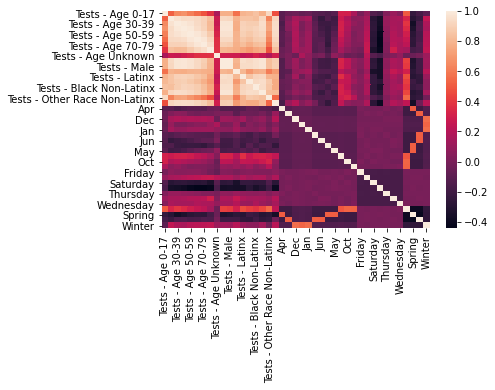

In [5]:
dfn_corr = dfn.corr()## show the corr matrix ##
sns.heatmap(dfn_corr)

In [6]:

# Create correlation matrix
corr_matrix = dfp.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
dfp=dfp.drop(dfp[to_drop], axis=1)

dfp

,Tests - Age 0-17,Tests - Age 18-29,Tests - Age 80+,Tests - Age Unknown,Tests - Gender Unknown,Tests - Latinx,Tests - Asian Non-Latinx,Tests - Other Race Non-Latinx,Tests - Unknown Race/Ethnicity,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Autumn,Spring,Summer,Winter
0,179,639,247,10,68,376,100,98,1483,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,844,2425,236,2,105,1896,313,498,2442,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,567,1902,164,1,143,811,250,389,1788,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1354,5231,734,10,609,3566,786,825,7087,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1114,5098,626,5,356,3154,683,840,6079,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,506,1661,173,3,52,824,253,392,1589,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
630,1367,4817,646,5,267,3623,791,726,6879,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
631,1271,4597,621,11,246,3534,662,683,5518,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
632,1201,4187,505,6,193,2839,546,753,4786,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [7]:

# Create correlation matrix
corr_matrix = dfn.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
dfn=dfn.drop(dfn[to_drop], axis=1)

dfn

,Tests - Age 0-17,Tests - Age 18-29,Tests - Age 80+,Tests - Age Unknown,Tests - Gender Unknown,Tests - Latinx,Tests - Asian Non-Latinx,Tests - Other Race Non-Latinx,Tests - Unknown Race/Ethnicity,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Autumn,Spring,Summer,Winter
0,179,639,247,10,68,376,100,98,1483,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,844,2425,236,2,105,1896,313,498,2442,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,567,1902,164,1,143,811,250,389,1788,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1354,5231,734,10,609,3566,786,825,7087,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1114,5098,626,5,356,3154,683,840,6079,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,506,1661,173,3,52,824,253,392,1589,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
630,1367,4817,646,5,267,3623,791,726,6879,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
631,1271,4597,621,11,246,3534,662,683,5518,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
632,1201,4187,505,6,193,2839,546,753,4786,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [8]:
df

,unique_id_zaada,Date,Positive Tests,Not Positive Tests,Total Tests,Day,Tests - Age 0-17,Tests - Age 18-29,Tests - Age 30-39,Tests - Age 40-49,Tests - Age 50-59,Tests - Age 60-69,Tests - Age 70-79,Tests - Age 80+,Tests - Age Unknown,Tests - Female,Tests - Male,Tests - Gender Unknown,Tests - Latinx,Tests - Asian Non-Latinx,Tests - Black Non-Latinx,Tests - White Non-Latinx,Tests - Other Race Non-Latinx,Tests - Unknown Race/Ethnicity,Positive Tests - Age 0-17,Positive Tests - Age 18-29,Positive Tests - Age 30-39,Positive Tests - Age 40-49,Positive Tests - Age 50-59,Positive Tests - Age 60-69,Positive Tests - Age 70-79,Positive Tests - Age 80+,Positive Tests - Age Unknown,Positive Tests - Female,Positive Tests - Male,Positive Tests - Unknown Gender,Positive Tests - Latinx,Positive Tests - Asian Non-Latinx,Positive Tests - Black Non-Latinx,Positive Tests - White Non-Latinx,Positive Tests - Other Race Non-Latinx,Positive Tests - Unknown Race/Ethnicity,Not-Positive Tests - Age 0-17,Not-Positive Tests - Age 18-29,Not-Positive Tests - Age 30-39,Not-Positive Tests - Age 40-49,Not-Positive Tests - Age 50-59,Not-Positive Tests - Age 60-69,Not-Positive Tests - Age 70-79,Not-Positive Tests - Age 80+,Not-Positive Tests - Age Unknown,Not-Positive Tests - Female,Not-Positive Tests - Male,Not-Positive Tests - Gender Unknown,Not-Positive Tests - Latinx,Not-Positive Tests - Asian Non-Latinx,Not-Positive Tests - Black Non-Latinx,Not-Positive Tests - White Non-Latinx,Not-Positive Tests - Other Race Non-Latinx,Not-Positive Tests - Unknown Race/Ethnicity,Month,Season
408,409,01/01/2021,304,3261,3565,Friday,179,639,639,499,527,516,309,247,10,1827,1670,68,376,100,735,773,98,1483,28,59,55,41,42,28,30,20,1,149,154,1,85,8,62,101,13,35,151,580,584,458,485,488,279,227,9,1678,1516,67,291,92,673,672,85,1448,Jan,Winter
49,50,01/02/2021,1255,8019,9274,Saturday,844,2425,1965,1304,1150,890,458,236,2,5022,4147,105,1896,313,1325,2800,498,2442,132,296,244,212,178,99,61,33,0,653,598,4,549,45,175,343,52,91,712,2129,1721,1092,972,791,397,203,2,4369,3549,101,1347,268,1150,2457,446,2351,Jan,Winter
490,491,01/03/2021,743,5812,6555,Sunday,567,1902,1459,879,748,537,298,164,1,3461,2951,143,811,250,1027,2290,389,1788,80,204,138,93,90,72,43,23,0,381,361,1,202,45,138,264,22,72,487,1698,1321,786,658,465,255,141,1,3080,2590,142,609,205,889,2026,367,1716,Jan,Winter
323,324,01/04/2021,2055,18596,20651,Monday,1354,5231,4363,2954,2694,2186,1125,734,10,10938,9104,609,3566,786,3429,4958,825,7087,241,503,409,338,277,148,86,53,0,1074,968,13,840,71,359,477,89,219,1113,4728,3954,2616,2417,2038,1039,681,10,9864,8136,596,2726,715,3070,4481,736,6868,Jan,Winter
188,189,01/05/2021,1773,16452,18225,Tuesday,1114,5098,3767,2650,2391,1729,845,626,5,9826,8043,356,3154,683,3102,4367,840,6079,181,527,332,246,214,147,79,45,2,909,860,4,696,63,298,454,76,186,933,4571,3435,2404,2177,1582,766,581,3,8917,7183,352,2458,620,2804,3913,764,5893,Jan,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,187,12/27/2020,720,5490,6210,Sunday,506,1661,1409,846,764,569,279,173,3,3361,2797,52,824,253,950,2202,392,1589,54,152,140,95,106,87,50,36,0,375,340,5,212,32,135,239,35,67,452,1509,1269,751,658,482,229,137,3,2986,2457,47,612,221,815,1963,357,1522,Dec,Winter
370,371,12/28/2020,1974,17520,19494,Monday,1367,4817,4291,2834,2584,1948,1002,646,5,10750,8477,267,3623,791,3110,4365,726,6879,231,441,404,273,291,210,80,43,1,1013,955,6,841,79,339,403,75,237,1136,4376,3887,2561,2293,1738,922,603,4,9737,7522,261,2782,712,2771,3962,651,6642,Dec,Winter
240,241,12/29/2020,1991,15505,17496,Tuesday,1271,4597,3850,2440,2229,1619,858,621,11,9479,7771,246,3534,662,2861,4238,683,5518,243,453,394,301,262,183,90,62,3,1058,926,7,889,61,332,434,81,194,1028,4144,3456,2139,1967,1436,768,559,8,8421,6845,239,2645,601,2529,3804,602,5324,Dec,

In [9]:
x_positive = dfp.values ## take the x's as the featuers list ##
x_positive_reg=np.append(arr=np.ones((len(x_positive),1)).astype(int),values=x_positive ,axis=1)## add a colum of 1 to the array for the x0 #


# ##for the Positive regressions  ##
# X_train_p, X_test_p, y_train_p, y_test_p =train_test_split(StandardScaler().fit_transform(x_reg), y_positive, test_size = 0.333333,random_state = 0)
# ##for the negative regressions##
# X_train_n, X_test_n, y_train_n, y_test_n =train_test_split(StandardScaler().fit_transform(x_reg), y_negative, test_size = 0.333333,random_state = 0)



X_temp_p, X_train_p, y_temp_p, y_train_p =train_test_split(StandardScaler().fit_transform(x_positive_reg), y_positive, test_size = 0.4,random_state = 0)
X_test_p, X_val_p, y_test_p, y_val_p =train_test_split(X_temp_p,y_temp_p, test_size = 0.5,random_state = 0) 


In [10]:
x_negative = dfn.values ## last col
x_negative_reg=np.append(arr=np.ones((len(x_negative),1)).astype(int),values=x_negative ,axis=1)## add a colum of 1 to the array for the x0 #
##split to train test and validation data sets ## 

## negative train test and validate ## 
X_temp_n, X_train_n, y_temp_n, y_train_n =train_test_split(StandardScaler().fit_transform(x_negative_reg), y_negative, test_size = 0.4,random_state = 0)
X_test_n, X_val_n, y_test_n, y_val_n =train_test_split(X_temp_n,y_temp_n, test_size = 0.5,random_state = 0)


linear regression Positive
_______________________________________
Root_mean_squared_error is 215.5119492545509
r^2 socre is  0.8987470737732598
avg of cross validation score is  0.73755162897964
std cross validation score is  0.2156660150686859


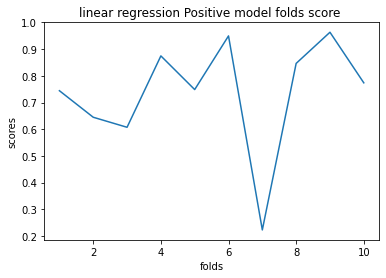

In [15]:
##multiply linear regression for the postive ##
print("linear regression Positive")
print("_______________________________________")
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

regressor_p = LinearRegression() ## make regression # 
regressor_p.fit(X_train_p, y_train_p)# train the model #

y_pred = regressor_p.predict(X_test_p)## the predication of postive ## 
error = y_test_p-y_pred




RMSE=sqrt(mean_squared_error(y_test_p,y_pred))## calc the RMSE #
score=r2_score(y_test_p,y_pred)# calc the r^2##
print("Root_mean_squared_error is",RMSE)
print("r^2 socre is ",score)

#inert into the dicts ## 
postive_vals["linear  regression "]=RMSE
postive_vals_r2["linear  regression "]=score



## make cross validation and take the score for the dicts ##
scores=cross_val_score(estimator=regressor_p,X=X_val_p,y=y_val_p,cv=10,scoring='r2',) #you can also try scoring=‘r2’
folds=range(1,11)
## make a fig that show each fold r^2 score 
plt.plot(folds,scores)
plt.title('linear regression Positive model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
postive_vals_std["linear  regression "]=std(scores) 
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores)) 
postive_vals_mr2["linear  regression "]=mean(scores) 
plt.show()



In [ ]:
##multiply linear regression for negative ##
print("linear regression Negative")
print("_______________________________________")
## same just for the negative ##

regressor_n = LinearRegression()
regressor_n.fit(X_train_n, y_train_n)

y_pred = regressor_n.predict(X_test_n)## the predication of postive ## 
error = y_test_n-y_pred## the postive eror##
error




RMSE=sqrt(mean_squared_error(y_test_n,y_pred))
score=r2_score(y_test_n,y_pred)
print("Root mean_squared_error is",RMSE)
print("r^2 socre is ",score)

negative_vals["linear  regression "]=RMSE
negative_vals_r2["linear  regression "]=score

scores=cross_val_score(estimator=regressor_n,X=X_val_n,y=y_val_n,cv=10,scoring='r2') #you can also try scoring=‘r2’
folds=range(1,11)
plt.plot(folds,scores)
plt.title('linear  regression negative model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))
negative_vals_std["linear  regression "]=std(scores)
negative_vals_mr2["linear  regression "]=mean(scores) 

plt.show()

Positives_validation


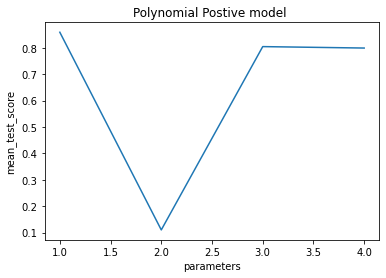

-----!!!!!!!
The Best Dgree is :1


In [12]:
## Polynomial regression

rs=[]

print("Positives_validation")

best=0 ## best degree #
d2=0# temp#
r2g=dict()

#check what is the best dgree for poly reg ## 
for i in range(1,5) :
    poly_reg_p = PolynomialFeatures(degree = i)## poly reg with dgree of i ##
    x_polyp = poly_reg_p.fit_transform(X_val_p)## poly the validation set ##
    x_poly_train = poly_reg_p.fit_transform(X_train_p) ## poly the test data set ## 

    lin_reg_p = LinearRegression() 
    linp=lin_reg_p.fit(x_poly_train, y_train_p) ## train the data ##

    ##Evaluation for  dgree##
    y_poly_pred=lin_reg_p.predict(poly_reg_p.fit_transform(X_val_p))

    RMSE = sqrt(mean_squared_error(y_val_p,y_poly_pred))
    r2 = r2_score(y_val_p,y_poly_pred)
    
    if r2>d2 :## pick the best r^2 ##
        best=i
        d2=r2
    # report performance
    r2g[i]=r2
    rs.append(r2)

plt.plot(range(1,5),rs)
plt.title('Polynomial Postive model ')
plt.xlabel('parameters')
plt.ylabel('mean_test_score')
plt.show()
print("-----!!!!!!!")
print("The Best Dgree is :"+str(best))

polynumial Positive test
_______________________________________
Root mean_squared_error is 215.51194925455115
r^2 socre is  0.8987470737732596


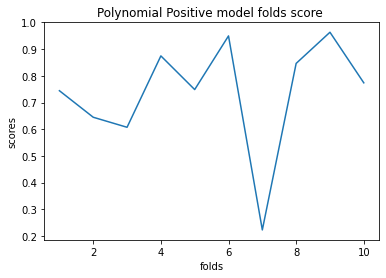

avg of cross validation score is  0.73755162897964
std cross validation score is  0.2156660150686859


In [13]:
#polynumial regression using 1dgree as the dgree beacuse lowest std in cross validation & have the highest r^2 ## 
##test !!!!!!!##

##postives##
print("polynumial Positive test")
print("_______________________________________")
poly_reg = PolynomialFeatures(degree = 1)## make polyni,ail##
xp = poly_reg.fit_transform(X_train_p)## make x polynomial##

poly_regressor_p = LinearRegression()
poly_regressor_p.fit(xp, y_train_p)

xt = poly_reg.fit_transform(X_test_p)## make x polynomial##
y_pred = poly_regressor_p.predict(xt)## the predication of postive ## 
error = y_test_p-y_pred## the postive eror##
error

RMSE=sqrt(mean_squared_error(y_test_p,y_pred))
score=r2_score(y_test_p,y_pred)
print("Root mean_squared_error is",RMSE)
print("r^2 socre is ",score)

postive_vals["polynumial regression"]=RMSE
postive_vals_r2["polynumial regression"]=score

scores=cross_val_score(estimator=poly_regressor_p,X=X_val_p,y=y_val_p,cv=10,scoring='r2') #you can also try scoring=‘r2’
folds=range(1,11)

plt.plot(folds,scores)
plt.title('Polynomial Positive model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
 
plt.show()

print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))
postive_vals_std["polynumial regression"]=std(scores)
postive_vals_mr2["polynumial regression"]=mean(scores)

Polynomial Negatives validation
-----!!!!!!!
The Best Dgree is :1


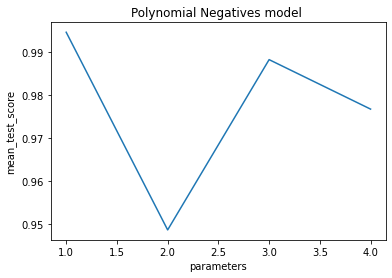

In [14]:

print("Polynomial Negatives validation")
best=0
d2=0
rs=[]
for i in range(1,5):
    poly_reg = PolynomialFeatures(degree = i)## make polyni,ail##
    x_noly = poly_reg.fit_transform(X_val_n)## make x polynomial##
    xn = poly_reg.fit_transform(X_train_n)## make x polynomial##

    lin_reg_2 = LinearRegression()
    lin2=lin_reg_2.fit(xn,y_train_n)

    #Evalation#
    y_noly_nred=lin_reg_2.predict(poly_reg.fit_transform(X_val_n))
    RMSE = sqrt(mean_squared_error(y_val_n,y_noly_nred))
    r2 = r2_score(y_val_n,y_noly_nred)

    if r2>d2 :
        best=i
        d2=r2
    
    rs.append(r2)

print("-----!!!!!!!")
print("The Best Dgree is :"+str(best))
plt.plot(range(1,5),rs)
plt.title('Polynomial Negatives model ')
plt.xlabel('parameters')
plt.ylabel('mean_test_score')
plt.show()


polynumial Negative test
_______________________
_________________
Root mean_squared_error is 461.2992767841144
r^2 socre is  0.9950778001951789
_________________


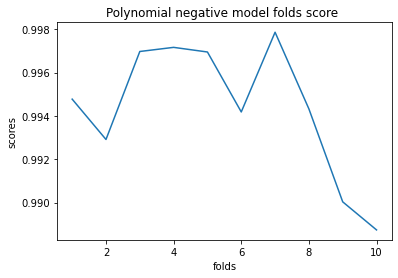

avg of cross validation score is  0.9943901853900804
std cross validation score is  0.003094701590796904


In [15]:
#polynumial regression using 1dgree as the dgree beacuse lowest std in cross validation & have the highest r^2 ## 

#negative ## 

print("polynumial Negative test")
print("_______________________")
poly_reg = PolynomialFeatures(degree = 1)## make polyni,ail##
xp = poly_reg.fit_transform(X_train_n)## make x polynomial##

poly_regressor_n = LinearRegression()
poly_regressor_n.fit(xp, y_train_n)

xt = poly_reg.fit_transform(X_test_n)## make x polynomial##
y_pred = poly_regressor_n.predict(xt)## the predication of postive ## 
error = y_test_n-y_pred## the postive eror##
error


print("_________________")
RMSE=sqrt(mean_squared_error(y_test_n,y_pred))
score=r2_score(y_test_n,y_pred)
print("Root mean_squared_error is",RMSE)
print("r^2 socre is ",score)

negative_vals["polynumial regression"]=RMSE
negative_vals_r2["polynumial regression"]=score


scores=cross_val_score(estimator=poly_regressor_p,X=X_val_n,y=y_val_n,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Polynomial negative model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
 
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))
negative_vals_std["polynumial regression"]=std(scores)
negative_vals_mr2["polynumial regression"]=mean(scores)

Ridge Positive stats
_______________________________
best alpha is  Ridge(alpha=0.01)
Root mean_squared_error is 215.6068280321896
r^2 socre is 0.8986579012834309
_________________


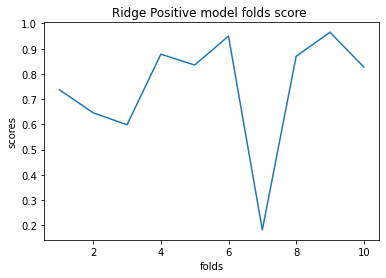

avg of cross validation score is  0.748838371403256
std cross validation score is  0.2327570936428045


In [16]:
####Ridge##
#positive####
print("Ridge","Positive stats")
print("_______________________________")

from numpy import arange
from pandas import read_csv
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold


parameters = {'alpha':arange(0, 1, 0.01)}

# define the model/ estimator
model = Ridge()

# define the grid search
Ridge_reg= GridSearchCV(model, parameters, scoring='r2',cv=5)

Ridge_reg.fit(X_train_p,y_train_p)
# best estimator#
print("best alpha is ",Ridge_reg.best_estimator_)

Ridge_p = Ridge_reg.best_estimator_
Ridge_p.fit(X_train_p, y_train_p)             
pred2 = Ridge_p.predict(X_test_p) 

error = y_test_p-pred2## the postive eror##

RMSE=sqrt(mean_squared_error(y_test_p,pred2))
score=r2_score(y_test_p,pred2)
print("Root mean_squared_error is",RMSE)
print("r^2 socre is "+ str(score))


postive_vals["Ridge regression"]=RMSE
postive_vals_r2["Ridge regression"]=score

scores=cross_val_score(estimator=Ridge_p,X=X_val_p,y=y_val_p,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Ridge Positive model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
 
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))
postive_vals_std["Ridge regression"]=std(scores)
postive_vals_mr2["Ridge regression"]=mean(scores)

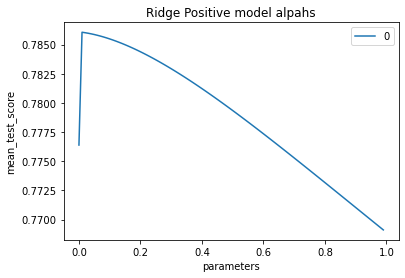

In [17]:
cvv=pd.DataFrame(Ridge_reg.cv_results_['mean_test_score'],Ridge_reg.cv_results_['param_alpha'])
cvv.plot()
plt.title('Ridge Positive model alpahs')
plt.xlabel('parameters')
plt.ylabel('mean_test_score')
plt.show()


Ridge Negative stats
_______________________________
best alpha is  Ridge(alpha=0.01)
Root mean_squared_error is 461.3858454700837
r^2 socre is 0.9950759525948337
_________________


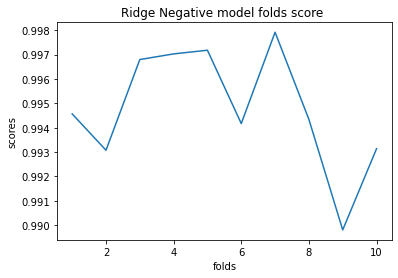

avg of cross validation score is  0.9948007914720538
std cross validation score is  0.0024864792224565456


In [18]:
####Ridge##
#Negative####
print("Ridge","Negative stats")
print("_______________________________")
# took from https://machinelearningmastery.com/ridge-regression-with-python/#
from numpy import arange
from pandas import read_csv
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

parameters = {'alpha':arange(0, 1, 0.01)}

# define the model/ estimator
model = Ridge()

# define the grid search
Ridge_reg= GridSearchCV(model, parameters, scoring='r2',cv=10)

Ridge_reg.fit(X_train_n,y_train_n)

cvv=pd.DataFrame(Ridge_reg.cv_results_)
# best estimator
print("best alpha is ",Ridge_reg.best_estimator_)

Ridge_n = Ridge_reg.best_estimator_
Ridge_n.fit(X_train_n, y_train_n)             
pred3 = Ridge_n.predict(X_test_n)  
error = y_test_n-pred3## the postive eror##

RMSE=sqrt(mean_squared_error(y_test_n,pred3))
score=r2_score(y_test_n,pred3)
print("Root mean_squared_error is",RMSE)
print("r^2 socre is "+ str(score))

negative_vals["Ridge regression"]=RMSE
negative_vals_r2["Ridge regression"]=score

scores=cross_val_score(estimator=Ridge_n,X=X_val_n,y=y_val_n,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Ridge Negative model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
 
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))
negative_vals_std["Ridge regression"]=std(scores)
negative_vals_mr2["Ridge regression"]=mean(scores)

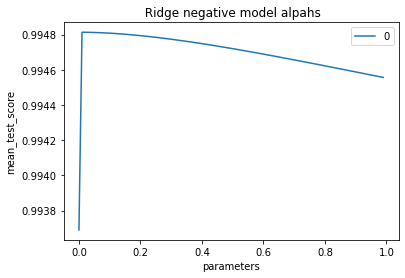

In [19]:
cvv=pd.DataFrame(Ridge_reg.cv_results_['mean_test_score'],Ridge_reg.cv_results_['param_alpha'])
cvv.plot()
plt.title(' Ridge negative model alpahs')
plt.xlabel('parameters')
plt.ylabel('mean_test_score')
plt.show()

Lasso Positive stats
_______________________________
best alpha is  Lasso(alpha=1.01)
Root mean_squared_error is 219.42725376157665
r^2 socre is 0.8950346378036509
_________________


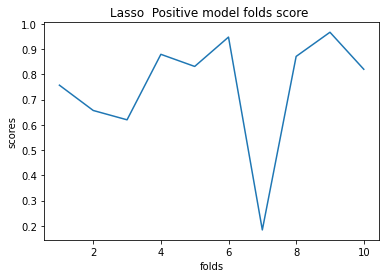

avg of cross validation score is  0.7533153229292806
std cross validation score is  0.22962631463557134


In [20]:
####Lasso##
#Positive####
print("Lasso","Positive stats")
print("_______________________________")


parameters = {'alpha':arange(0, 10, 0.01)}

# define the model/ estimator
model = Lasso()

# define the grid search
Lasso_reg= GridSearchCV(model, parameters, scoring='r2',cv=10)

Lasso_reg.fit(X_train_p,y_train_p)

# best estimator
print("best alpha is ",Lasso_reg.best_estimator_)


lasso_p = Lasso_reg.best_estimator_# Fit the Lasso model
lasso_p.fit(X_train_p, y_train_p)# Create the model score
lasso_pred=lasso_p.predict(X_test_p)


RMSE=sqrt(mean_squared_error(y_test_p,lasso_pred))
score=r2_score(y_test_p,lasso_pred)
print("Root mean_squared_error is",RMSE)
print("r^2 socre is "+ str(score))


postive_vals["Lasso regression"]=RMSE
postive_vals_r2["Lasso regression"]=score


scores=cross_val_score(estimator=lasso_p,X=X_val_p,y=y_val_p,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Lasso  Positive model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
 
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))
postive_vals_std["Lasso regression"]=std(scores)
postive_vals_mr2["Lasso regression"]=mean(scores)

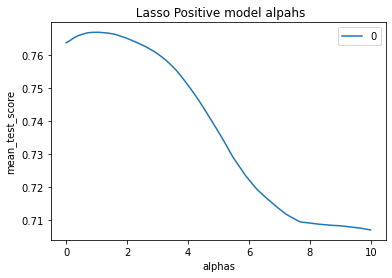

In [21]:
cvv=pd.DataFrame(Lasso_reg.cv_results_['mean_test_score'],Lasso_reg.cv_results_['param_alpha'])
cvv.plot()
plt.title(' Lasso Positive model alpahs')
plt.xlabel('alphas')
plt.ylabel('mean_test_score')
plt.show()
temp=pd.DataFrame(Ridge_reg.cv_results_)

Lasso Negative stats
_______________________________
best alpha is  Lasso(alpha=3.31)
Root mean_squared_error is 465.455166656848
r^2 socre is 0.9949887115408524
_________________


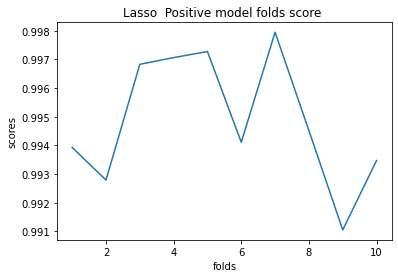

avg of cross validation score is  0.9948992617730607
std cross validation score is  0.0022689251407351798


In [22]:
####Lasso##
#Negative####
print("Lasso","Negative stats")
print("_______________________________")

parameters = {'alpha':arange(0, 10, 0.01)}

# define the model/ estimator
model = Lasso()

# define the grid search
Lasso_reg= GridSearchCV(model, parameters, scoring='r2',cv=10)

Lasso_reg.fit(X_train_n,y_train_n)

# best estimator
print("best alpha is ",Lasso_reg.best_estimator_)


lasso_n = Lasso_reg.best_estimator_# Fit the Lasso model
lasso_n.fit(X_train_n, y_train_n)# Create the model score
lasso_nred=lasso_n.predict(X_test_n)

RMSE=sqrt(mean_squared_error(y_test_n,lasso_nred))
score=r2_score(y_test_n,lasso_nred)
print("Root mean_squared_error is",RMSE)
print("r^2 socre is "+ str(score))

negative_vals["Lasso regression"]=RMSE
negative_vals_r2["Lasso regression"]=score


scores=cross_val_score(estimator=lasso_n,X=X_val_n,y=y_val_n,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Lasso  Positive model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
 
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))

negative_vals_std["Lasso regression"]=std(scores)
negative_vals_mr2["Lasso regression"]=mean(scores)


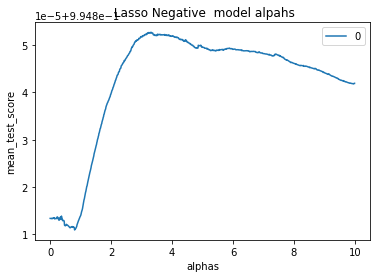

In [23]:
cvv=pd.DataFrame(Lasso_reg.cv_results_['mean_test_score'],Lasso_reg.cv_results_['param_alpha'])
cvv.plot()
plt.title(' Lasso Negative  model alpahs')
plt.xlabel('alphas')
plt.ylabel('mean_test_score')
plt.show()


Positive Knn
___________________________
best k {'n_neighbors': 5}
Root mean_squared_error is 340.8529202796389
r^2 socre is 0.7467211581719533
_________________


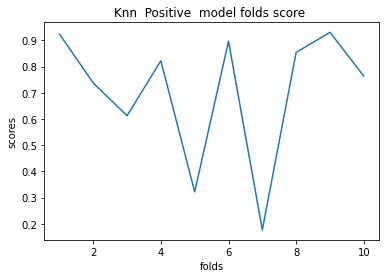

avg of cross validation score is  0.7040776220694468
std cross validation score is  0.2607471321227376


In [24]:
##Positive Knn###

#not regression so dont need colum of 1's ##
X_temp_p, X_train_p, y_temp_p, y_train_p =train_test_split(StandardScaler().fit_transform(x_positive), y_positive, test_size = 0.4,random_state = 0)
X_test_p, X_val_p, y_test_p, y_val_p =train_test_split(X_temp_p,y_temp_p, test_size = 0.5,random_state = 0) 

## negative train test and validate ## 
X_temp_n, X_train_n, y_temp_n, y_train_n =train_test_split(StandardScaler().fit_transform(x_negative), y_negative, test_size = 0.4,random_state = 0)
X_test_n, X_val_n, y_test_n, y_val_n =train_test_split(X_temp_n,y_temp_n, test_size = 0.5,random_state = 0)



print("Positive Knn")
print("___________________________")




knn = KNeighborsRegressor()
from sklearn.model_selection import GridSearchCV
k_range = list(range(1,70))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='r2',)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_p, y_train_p)
print("best k",grid.best_params_)

knn_model_p=grid.best_estimator_
knn_model_p.fit(X_train_p, y_train_p)
y_pred_knn = knn_model_p.predict(X_test_p)

RMSE=sqrt(mean_squared_error(y_test_p,y_pred_knn))
score=r2_score(y_test_p,y_pred_knn)
print("Root mean_squared_error is",RMSE)
print("r^2 socre is "+ str(score))


postive_vals["Knn regression "]=RMSE
postive_vals_r2["Knn regression "]=score

scores=cross_val_score(estimator=knn_model_p,X=X_val_p,y=y_val_p,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Knn  Positive  model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
 
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))

postive_vals_std["Knn regression "]=std(scores)
postive_vals_mr2["Knn regression "]=mean(scores)


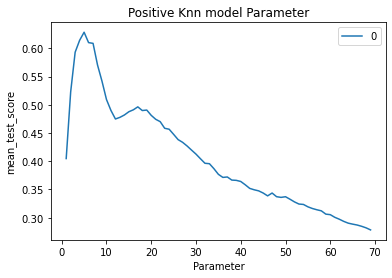

In [25]:
cvv=pd.DataFrame(grid_search.cv_results_['mean_test_score'],grid_search.cv_results_['param_n_neighbors'])
cvv.plot()
plt.title('Positive Knn model Parameter')
plt.xlabel('Parameter')
plt.ylabel('mean_test_score')
plt.show()


Negative Knn
___________________________
best k KNeighborsRegressor(n_neighbors=1)
Root mean_squared_error is 2334.0475178944994
r^2 socre is 0.8739876594437342
_________________


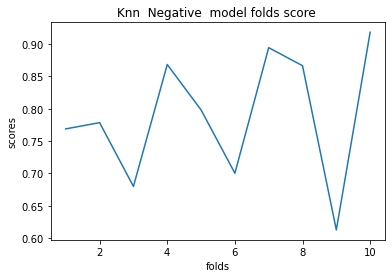

avg of cross validation score is  0.7885355108885024
std cross validation score is  0.10093292145489234


In [26]:
##Negative ###

print("Negative Knn")
print("___________________________")

knn = KNeighborsRegressor()

param_grid = {'n_neighbors': (1,70, 1)}
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='r2',   n_jobs = -1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_n, y_train_n)
#print(grid.grid_scores_)
print("best k",grid.best_estimator_)

knn_model_n=grid.best_estimator_
knn_model_n.fit(X_train_n, y_train_n)
y_nred_knn = knn_model_n.predict(X_test_n)

RMSE=sqrt(mean_squared_error(y_test_n,y_nred_knn))
score=r2_score(y_test_n,y_nred_knn)
print("Root mean_squared_error is",RMSE)
print("r^2 socre is "+ str(score))

negative_vals["Knn regression "]=RMSE
negative_vals_r2["Knn regression "]=score


scores=cross_val_score(estimator=knn_model_n,X=X_val_n,y=y_val_n,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Knn  Negative  model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
 
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))

negative_vals_std["Knn regression "]=std(scores)
negative_vals_mr2["Knn regression "]=mean(scores)


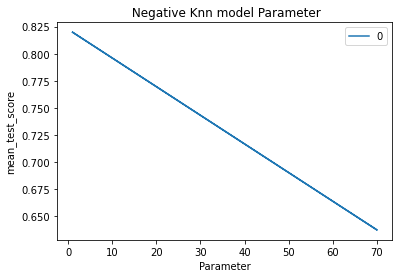

In [27]:
cvv=pd.DataFrame(grid_search.cv_results_['mean_test_score'],grid_search.cv_results_['param_n_neighbors'])
cvv.plot()
plt.title(' Negative Knn model Parameter')
plt.xlabel('Parameter')
plt.ylabel('mean_test_score')
plt.show()


Positive Random Forst 
_______________________________
Best parameters are  {'bootstrap': True, 'max_depth': None, 'n_estimators': 129}
Root mean_squared_error is 286.3150645080719
r^2 socre is 0.8212881825885809
_________________


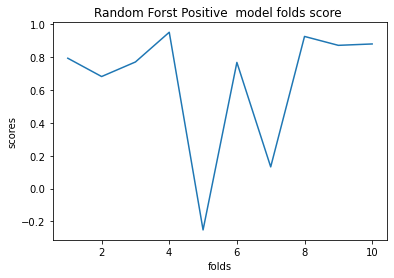

avg of cross validation score is  0.6515748432640451
std cross validation score is  0.39402606446596616


In [28]:
#Positive#
print("Positive Random Forst ")
print("_______________________________")

param_grid = {  'bootstrap': [True], 'max_depth': [range(1,10),None], 'n_estimators': range(1,150)}
rfr = RandomForestRegressor(random_state = 1)
g_search = GridSearchCV(estimator = rfr, param_grid = param_grid,scoring='r2', cv = 10, n_jobs = -1)
g_search.fit(X_train_p, y_train_p);
print("Best parameters are ",g_search.best_params_)

Random_f_p =g_search.best_estimator_
# fit the model on the whole dataset
Random_f_p.fit(X_train_p, y_train_p)

y_pred = Random_f_p.predict(X_test_p)

RMSE=sqrt(mean_squared_error(y_test_p,y_pred))
score=r2_score(y_test_p,y_pred)
print("Root mean_squared_error is",RMSE)
print("r^2 socre is "+ str(score))


postive_vals["Random Forst regression "]=RMSE
postive_vals_r2["Random Forst regression "]=score


scores=cross_val_score(estimator=Random_f_p,X=X_val_p,y=y_val_p,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Random Forst Positive  model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))

postive_vals_std["Random Forst regression "]=std(scores)
postive_vals_mr2["Random Forst regression "]=mean(scores)

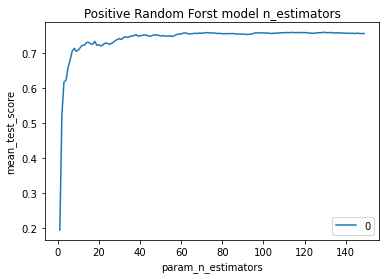

In [29]:
cvv=pd.DataFrame(g_search.cv_results_['mean_test_score'],g_search.cv_results_['param_n_estimators'])
cvv.plot()
plt.title('Positive Random Forst model n_estimators')
plt.xlabel('param_n_estimators')
plt.ylabel('mean_test_score')
plt.show()


temp=pd.DataFrame(g_search.cv_results_)

Negative Random Forst 
_______________________________
Best parameters are  {'bootstrap': True, 'max_depth': None, 'n_estimators': 93}
Root mean_squared_error is 727.0803994982858
r^2 socre is 0.987771911711295
_________________


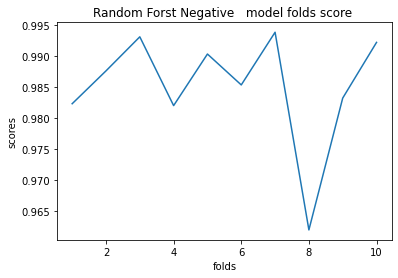

avg of cross validation score is  0.9851928154249086
std cross validation score is  0.009315722211349596


In [30]:
#Negative#
print("Negative Random Forst ")
print("_______________________________")
param_grid = {'bootstrap': [True], 'max_depth': [range(1,10),None],'n_estimators':range(1,150)}
rfr = RandomForestRegressor(random_state = 1)
g_search = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 10, n_jobs = -1)
g_search.fit(X_train_n, y_train_n);
print("Best parameters are ",g_search.best_params_)

Random_f_n =g_search.best_estimator_
# fit the model on the whole dataset
Random_f_n.fit(X_train_n, y_train_n)

y_nred = Random_f_n.predict(X_test_n)

RMSE=sqrt(mean_squared_error(y_test_n,y_nred))
score=r2_score(y_test_n,y_nred)
print("Root mean_squared_error is",RMSE)
print("r^2 socre is "+ str(score))

negative_vals["Random Forst regression "]=RMSE
negative_vals_r2["Random Forst regression "]=score



scores=cross_val_score(estimator=Random_f_n,X=X_val_n,y=y_val_n,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Random Forst Negative   model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))\

negative_vals_std["Random Forst regression "]=std(scores)
negative_vals_mr2["Random Forst regression "]=mean(scores)

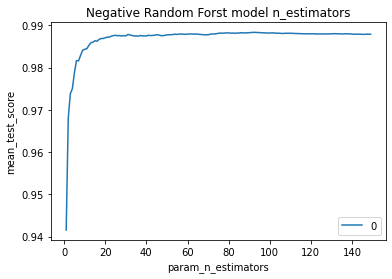

In [31]:
cvv=pd.DataFrame(g_search.cv_results_['mean_test_score'],g_search.cv_results_['param_n_estimators'])
cvv.plot()
plt.title('Negative Random Forst model n_estimators')
plt.xlabel('param_n_estimators')
plt.ylabel('mean_test_score')
plt.show()


In [32]:
print(negative_vals)
print("__________________________________________________________")
print(postive_vals)
print("__________________________________________________________")
print(postive_vals_r2)
print("__________________________________________________________")
print(negative_vals_r2)

{'linear  regression ': 461.29927678411354, 'polynumial regression': 461.2992767841144, 'Ridge regression': 461.3858454700837, 'Lasso regression': 465.455166656848, 'Knn regression ': 2334.0475178944994, 'Random Forst regression ': 727.0803994982858}
__________________________________________________________
{'linear  regression ': 215.5119492545509, 'polynumial regression': 215.51194925455115, 'Ridge regression': 215.6068280321896, 'Lasso regression': 219.42725376157665, 'Knn regression ': 340.8529202796389, 'Random Forst regression ': 286.3150645080719}
__________________________________________________________
{'linear  regression ': 0.8987470737732598, 'polynumial regression': 0.8987470737732596, 'Ridge regression': 0.8986579012834309, 'Lasso regression': 0.8950346378036509, 'Knn regression ': 0.7467211581719533, 'Random Forst regression ': 0.8212881825885809}
__________________________________________________________
{'linear  regression ': 0.995077800195179, 'polynumial regressio

In [33]:
max_key_negative_vals = min(negative_vals, key=negative_vals.get)
max_key_postive_vals = min(postive_vals, key=postive_vals.get)


max_key_negative_vals_r2 = max(negative_vals_r2, key=negative_vals_r2.get)
max_key_postive_vals_r2 = max(postive_vals_r2, key=postive_vals_r2.get)



print("Negative predication Best Model comared by Rmse is :",max_key_negative_vals)
print("Negative predication Best Model comared by r^2 is :",max_key_negative_vals_r2)

print("Positive predication Best Model comared by Rmse is :",max_key_postive_vals)
print("Positive predication Best Model comared by r^2 is :",max_key_postive_vals_r2)


Negative predication Best Model comared by Rmse is : linear  regression 
Negative predication Best Model comared by r^2 is : linear  regression 
Positive predication Best Model comared by Rmse is : linear  regression 
Positive predication Best Model comared by r^2 is : linear  regression 


In [34]:
postive_vals_mr2

{'linear  regression ': 0.73755162897964,
 'polynumial regression': 0.73755162897964,
 'Ridge regression': 0.748838371403256,
 'Lasso regression': 0.7533153229292806,
 'Knn regression ': 0.7040776220694468,
 'Random Forst regression ': 0.6515748432640451}

In [35]:
df1 = pd.DataFrame(list(negative_vals_r2.items()), columns=['name', 'r2_score_n'])
df2 = pd.DataFrame(list(negative_vals.items()), columns=['name', 'RMSE_score_n'])
df5=pd.DataFrame(list(negative_vals_std.items()), columns=['name', 'std_score_n'])
df7=pd.DataFrame(list(negative_vals_mr2.items()), columns=['name', 'mean_kfold_r^2_n'])

df_n=merge_fix_cols(df1,df2,'name')
df_n=merge_fix_cols(df_n,df5,'name')
df_n=merge_fix_cols(df_n,df7,'name')

df3 = pd.DataFrame(list(postive_vals_r2.items()), columns=['name', 'r2_score_p'])
df4 = pd.DataFrame(list(postive_vals.items()), columns=['name', 'RMSE_score_p'])
df6=pd.DataFrame(list(postive_vals_std.items()), columns=['name', 'std_score_p'])
df8=pd.DataFrame(list(postive_vals_mr2.items()), columns=['name', 'mean_kfold_r^2_p'])

df_p=merge_fix_cols(df3,df4,'name')
df_p=merge_fix_cols(df_p,df6,'name')
df_p=merge_fix_cols(df_p,df8,'name')

df=merge_fix_cols(df_p,df_n,'name')

In [36]:
df=df.round(decimals=4)

In [37]:
df.style.highlight_max(color = 'lightgreen',subset=['r2_score_p','r2_score_n',"mean_kfold_r^2_n","mean_kfold_r^2_p"], axis = 0).highlight_min(color = 'lightgreen',subset=['RMSE_score_p',"RMSE_score_n","std_score_n","std_score_p"], axis = 0).highlight_min(color = 'lightcoral',subset=['r2_score_p','r2_score_n',"mean_kfold_r^2_n","mean_kfold_r^2_p"], axis = 0).highlight_max(color = 'lightcoral',subset=['RMSE_score_p',"RMSE_score_n","std_score_n","std_score_p"], axis = 0)



,name,r2_score_p,RMSE_score_p,std_score_p,mean_kfold_r^2_p,r2_score_n,RMSE_score_n,std_score_n,mean_kfold_r^2_n
0,linear regression,0.898700,215.511900,0.215700,0.737600,0.995100,461.299300,0.003100,0.994400
1,polynumial regression,0.898700,215.511900,0.215700,0.737600,0.995100,461.299300,0.003100,0.994400
2,Ridge regression,0.898700,215.606800,0.232800,0.748800,0.995100,461.385800,0.002500,0.994800
3,Lasso regression,0.895000,219.427300,0.229600,0.753300,0.995000,465.455200,0.002300,0.994900
4,Knn regression,0.746700,340.852900,0.260700,0.704100,0.874000,2334.047500,0.100900,0.788500
5,Random Forst regression,0.821300,286.315100,0.394000,0.651600,0.987800,727.080400,0.009300,0.985200


In [38]:
df.round(decimals=4)

,name,r2_score_p,RMSE_score_p,std_score_p,mean_kfold_r^2_p,r2_score_n,RMSE_score_n,std_score_n,mean_kfold_r^2_n
0,linear regression,0.8987,215.5119,0.2157,0.7376,0.9951,461.2993,0.0031,0.9944
1,polynumial regression,0.8987,215.5119,0.2157,0.7376,0.9951,461.2993,0.0031,0.9944
2,Ridge regression,0.8987,215.6068,0.2328,0.7488,0.9951,461.3858,0.0025,0.9948
3,Lasso regression,0.8950,219.4273,0.2296,0.7533,0.9950,465.4552,0.0023,0.9949
4,Knn regression,0.7467,340.8529,0.2607,0.7041,0.8740,2334.0475,0.1009,0.7885
5,Random Forst regression,0.8213,286.3151,0.3940,0.6516,0.9878,727.0804,0.0093,0.9852


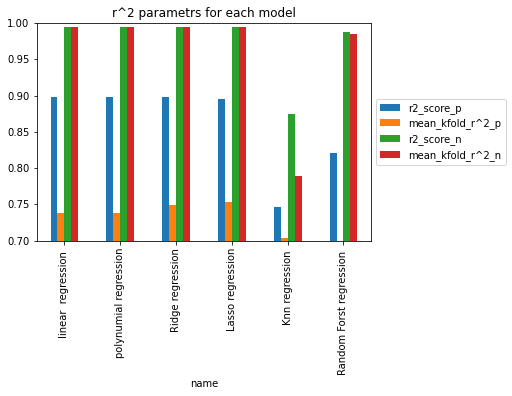

In [39]:
df.plot(x ='name', y=["r2_score_p","mean_kfold_r^2_p","r2_score_n","mean_kfold_r^2_n"], kind = 'bar')

plt.title('ww')## LABELS OF AXSIS ## 
plt.title('r^2 parametrs for each model')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),prop={"size":10})## THE LEGEND ##
plt.ylim(0.7, 1,0.01)
plt.rcParams["figure.figsize"] = (8,4)
plt.show()